# This part is used to create the Spectrograms for te train and test sets

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd
import os
from datetime import datetime, timedelta

# Step 1: Create Directory to Save Images and Labels
output_dir = "spectrograms_train"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

label_file = os.path.join(output_dir, "labels.csv")

# Step 2: Download Stock Data with Extended Periods
def download_data_with_extension(ticker, start_date, end_date, chunk_size_days, extension_days):
    """
    Download time series data for a given ticker, including an extension for future trend analysis.
    """
    current_date = start_date
    all_data = []

    while current_date < end_date:
        next_date = current_date + timedelta(days=chunk_size_days + extension_days)
        print(f"Downloading {ticker} data from {current_date} to {next_date}...")
        
        data = yf.download(ticker, start=current_date, end=next_date, progress=False)
        if not data.empty:
            all_data.append(data['Close'])
        
        current_date = current_date + timedelta(days=chunk_size_days)

    return pd.concat(all_data, axis=0)

# Step 3: Compute Future Trend Label
def compute_future_trend_label(future_period_prices, threshold=0.005):
    """
    Compute label based on the average price variation between current and future periods:
        2 -> Positive trend (average price increase > threshold)
        1 -> Neutral trend (within ±threshold)
       0 -> Negative trend (average price decrease > threshold)
    """
    if len(future_period_prices) == 0:
        return None
    
    price_change = (future_period_prices[-1]-future_period_prices[0])/future_period_prices[0]

    if price_change > threshold:
        return 2  # Upwards trend
    elif price_change < -threshold:
        return 0  # Downwards trend
    else:
        return 1  # Neutral trend

# Step 4: Generate Wavelet Spectrogram and Save Image
def generate_wavelet_spectrogram(signal, stock_name, period_num, wavelet='morl', scales=None):
    """
    Generate and save a spectrogram image using Continuous Wavelet Transform (CWT).
    """
    if scales is None:
        scales = np.arange(1, 128)

    # Perform Continuous Wavelet Transform
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet)
    
    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    plt.imshow(np.abs(coefficients), extent=[0, len(signal), 1, 128],
               interpolation='bilinear', aspect='auto', cmap='jet')
    plt.colorbar(label='Power')
    plt.ylabel('Frequency (Scale)')
    plt.xlabel('Time')
    plt.title(f'{stock_name} - Period {period_num} Spectrogram')

    # Save the image
    image_path = os.path.join(output_dir, f"{stock_name}_Period{period_num}.png")
    plt.savefig(image_path)
    plt.close()
    print(f"Saved spectrogram: {image_path}")

    return image_path


# Step 5: Process Stocks and Save Labels
def process_stocks(tickers, start_date, end_date, chunk_size_days=100, extension_days=30, threshold=0.005):
    """
    Download stock data, generate spectrograms, and assign labels based on future trends.
    """
    labels = []

    for ticker in tickers:
        print(f"Processing {ticker}...")
        try:
            # Download data with extension for future trend analysis
            close_prices = download_data_with_extension(ticker, start_date, end_date, chunk_size_days, extension_days)
            close_prices = close_prices.dropna()
            
            if len(close_prices) == 0:
                print(f"No valid data for {ticker}. Skipping...")
                continue
            
            # Process each 100-day period
            period_num = 1
            for i in range(0, len(close_prices) - chunk_size_days - extension_days + 1, chunk_size_days):
                current_chunk = close_prices.iloc[i:i + chunk_size_days].values
                future_chunk = close_prices.iloc[i + chunk_size_days:i + chunk_size_days + extension_days].values
                
                if len(current_chunk) < 2 or len(future_chunk) < 2:
                    continue
                
                # Compute label based on future trend
                label = compute_future_trend_label( future_chunk, threshold)
                if label is None:
                    continue
                
                # Generate and save spectrogram
                image_path = generate_wavelet_spectrogram(current_chunk, ticker, period_num)
                
                # Append to labels list
                labels.append([image_path, label])
                period_num += 1
                
        except Exception as e:
            print(f"Error processing {ticker}: {e}")

    # Save labels to CSV
    labels_df = pd.DataFrame(labels, columns=["image_path", "label"])
    labels_df.to_csv(label_file, index=False)
    print(f"Labels saved to {label_file}")


# Step 6: Main Execution
if __name__ == "__main__":
    # List of Stocks (First 10 for demonstration)
    tickers = [ "AAPL", "MSFT", "AMZN", "GOOG", "BRK-B", "NVDA", "JNJ", "JPM", "PG", "UNH", "HD", "MA", "DIS", "NFLX", "KO", "PEP",
    "CSCO", "XOM", "PFE", "MRK", "INTC", "BA", "WMT", "MCD", "IBM", "GS",
    "NKE", "ADBE", "HON", "AMGN", "T", "COST", "ABT", "LMT", "BMY", "CAT",
    "DHR", "MDT", "CVX", "ORCL", "CMCSA", "MS", "ISRG", "TXN", "UNP", "QCOM",
    "LIN", "PM", "SBUX", "AMAT", "MMM", "NEE", "BLK", "SPGI", "NOW", "GE",
    "LLY", "ZTS", "LOW", "TGT", "INTU", "ANTM", "MU", "FIS", "CSX", "VRTX",
    "GILD", "APD", "PLD", "ADI", "C", "DUK", "SYK", "USB", "SO", "SCHW",
    "MMC", "CL", "TJX", "BDX", "CI", "PNC", "CME", "NSC", "EW", "ETN",
    "ADI", "ROP", "FCX", "ICE", "TRV", "TMO", "GM", "AON", "FDX", "HUM"]
    
    # Define Date Range (2007 to 2017)
    start_date = datetime(2000, 1, 1)
    end_date = datetime(2014, 1, 1)
    
    # Process Stocks and Generate Spectrograms with Labels
    process_stocks(tickers, start_date, end_date)

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd
import os
from datetime import datetime, timedelta

# Step 1: Create Directory to Save Images and Labels
output_dir = "spectrograms_test"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

label_file = os.path.join(output_dir, "labels.csv")

# Step 2: Download Stock Data with Extended Periods
def download_data_with_extension(ticker, start_date, end_date, chunk_size_days, extension_days):
    """
    Download time series data for a given ticker, including an extension for future trend analysis.
    """
    current_date = start_date
    all_data = []

    while current_date < end_date:
        next_date = current_date + timedelta(days = chunk_size_days + extension_days)
        print(f"Downloading {ticker} data from {current_date} to {next_date}...")
        
        data = yf.download(ticker, start=current_date, end=next_date, progress=False)
        if not data.empty:
            all_data.append(data['Close'])
        
        current_date = current_date + timedelta(days=chunk_size_days)

    return pd.concat(all_data, axis=0)

# Step 3: Compute Future Trend Label
def compute_future_trend_label(future_period_prices, threshold=0.005):
    """
    Compute label based on the average price variation between current and future periods:
        2 -> Positive trend (average price increase > threshold)
        1 -> Neutral trend (within ±threshold)
       0 -> Negative trend (average price decrease > threshold)
    """
    if len(future_period_prices) == 0:
        return None
    
    price_change = (future_period_prices[-1]-future_period_prices[0])/future_period_prices[0]

    if price_change > threshold:
        return 2  # Upwards trend
    elif price_change < -threshold:
        return 0  # Downwards trend
    else:
        return 1  # Neutral trend

# Step 4: Generate Wavelet Spectrogram and Save Image
def generate_wavelet_spectrogram(signal, stock_name, period_num, wavelet='morl', scales=None):
    """
    Generate and save a spectrogram image using Continuous Wavelet Transform (CWT).
    """
    if scales is None:
        scales = np.arange(1, 128)

    # Perform Continuous Wavelet Transform
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet)
    
    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    plt.imshow(np.abs(coefficients), extent=[0, len(signal), 1, 128],
               interpolation='bilinear', aspect='auto', cmap='jet')
    plt.colorbar(label='Power')
    plt.ylabel('Frequency (Scale)')
    plt.xlabel('Time')
    plt.title(f'{stock_name} - Period {period_num} Spectrogram')

    # Save the image
    image_path = os.path.join(output_dir, f"{stock_name}_Period{period_num}.png")
    plt.savefig(image_path)
    plt.close()
    print(f"Saved spectrogram: {image_path}")

    return image_path


# Step 5: Process Stocks and Save Labels
def process_stocks(tickers, start_date, end_date, chunk_size_days=100, extension_days=30, threshold=0.005):
    """
    Download stock data, generate spectrograms, and assign labels based on future trends.
    """
    labels = []

    for ticker in tickers:
        print(f"Processing {ticker}...")
        try:
            # Download data with extension for future trend analysis
            close_prices = download_data_with_extension(ticker, start_date, end_date, chunk_size_days, extension_days)
            close_prices = close_prices.dropna()
            
            if len(close_prices) == 0:
                print(f"No valid data for {ticker}. Skipping...")
                continue
            
            # Process each 100-day period
            period_num = 1
            for i in range(0, len(close_prices) - chunk_size_days - extension_days + 1, chunk_size_days):
                current_chunk = close_prices.iloc[i:i + chunk_size_days].values
                future_chunk = close_prices.iloc[i + chunk_size_days:i + chunk_size_days + extension_days].values
                
                if len(current_chunk) < 2 or len(future_chunk) < 2:
                    continue
                
                # Compute label based on future trend
                label = compute_future_trend_label( future_chunk, threshold)
                if label is None:
                    continue
                
                # Generate and save spectrogram
                image_path = generate_wavelet_spectrogram(current_chunk, ticker, period_num)
                
                # Append to labels list
                labels.append([image_path, label])
                period_num += 1
                
        except Exception as e:
            print(f"Error processing {ticker}: {e}")

    # Save labels to CSV
    labels_df = pd.DataFrame(labels, columns=["image_path", "label"])
    labels_df.to_csv(label_file, index=False)
    print(f"Labels saved to {label_file}")


# Step 6: Main Execution
if __name__ == "__main__":
    # List of Stocks (First 10 for demonstration)
    tickers = [ "AAPL", "MSFT", "AMZN", "GOOG", "BRK-B", "NVDA", "JNJ", "JPM", "PG", "UNH", "HD", "MA", "DIS", "NFLX", "KO", "PEP",
    "CSCO", "XOM", "PFE", "MRK", "INTC", "BA", "WMT", "MCD", "IBM", "GS",
    "NKE", "ADBE", "HON", "AMGN", "T", "COST", "ABT", "LMT", "BMY", "CAT",
    "DHR", "MDT", "CVX", "ORCL", "CMCSA", "MS", "ISRG", "TXN", "UNP", "QCOM",
    "LIN", "PM", "SBUX", "AMAT", "MMM", "NEE", "BLK", "SPGI", "NOW", "GE",
    "LLY", "ZTS", "LOW", "TGT", "INTU", "ANTM", "MU", "FIS", "CSX", "VRTX",
    "GILD", "APD", "PLD", "ADI", "C", "DUK", "SYK", "USB", "SO", "SCHW",
    "MMC", "CL", "TJX", "BDX", "CI", "PNC", "CME", "NSC", "EW", "ETN",
    "ADI", "ROP", "FCX", "ICE", "TRV", "TMO", "GM", "AON", "FDX", "HUM"]
    
    # Define Date Range (2007 to 2017)
    start_date = datetime(2016, 1, 1)
    end_date = datetime(2019, 1, 1)
    
    # Process Stocks and Generate Spectrograms with Labels
    process_stocks(tickers, start_date, end_date)

---
# this part is used on colab to work with the images and create a ViTmodel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor
from google.colab import drive


# Configuration
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.0001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Dataset Class
class SpectrogramDataset(Dataset):
    def __init__(self, image_dir, labels_file, transform=None):
        self.image_dir = image_dir
        self.labels = pd.read_csv(labels_file)
        self.labels["label"] = self.labels["label"].astype(int)  # Ensure labels are integers
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.labels.iloc[idx, 0])
        if not os.path.exists(img_name):
            raise FileNotFoundError(f"Image not found: {img_name}")
        image = Image.open(img_name).convert("RGB")
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Load Data
train_image_dir = "/content/Unzipped/spectrograms_test/"
train_labels_file = "/content/Unzipped/spectrograms_test/spectrograms_test/labels.csv"
test_image_dir = "/content/Unzipped/spectrograms_test/"
test_labels_file = "/content/Unzipped/spectrograms_test/spectrograms_test/labels.csv"

train_dataset = SpectrogramDataset(image_dir=train_image_dir, labels_file=train_labels_file, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = SpectrogramDataset(image_dir=test_image_dir, labels_file=test_labels_file, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model Setup
num_classes = len(train_dataset.labels["label"].unique())
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes
)
model.to(DEVICE)

# Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Scheduler: Adjust learning rate dynamically
# Option 1: StepLR - Decay LR every 'step_size' epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# Option 2: ReduceLROnPlateau - Reduce LR when loss plateaus
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

# Training Loop
def train_model():
    model.train()
    for epoch in range(EPOCHS):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {avg_loss:.4f}")

        # Update learning rate scheduler
        scheduler.step()  # For StepLR
        # scheduler.step(avg_loss)  # For ReduceLROnPlateau
        print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

# Evaluation
def evaluate_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")

# Run Training and Evaluation
if __name__ == "__main__":
    print("Starting Training...")
    train_model()
    print("Evaluating Model...")
    evaluate_model()


Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training...
Epoch 1/50, Loss: 0.9259
Current Learning Rate: 0.000100
Epoch 2/50, Loss: 0.9149
Current Learning Rate: 0.000100
Epoch 3/50, Loss: 0.9209
Current Learning Rate: 0.000100
Epoch 4/50, Loss: 0.9106
Current Learning Rate: 0.000100
Epoch 5/50, Loss: 0.9043
Current Learning Rate: 0.000100
Epoch 6/50, Loss: 0.9042
Current Learning Rate: 0.000100
Epoch 7/50, Loss: 0.8959
Current Learning Rate: 0.000100
Epoch 8/50, Loss: 0.8749
Current Learning Rate: 0.000100
Epoch 9/50, Loss: 0.8586
Current Learning Rate: 0.000100
Epoch 10/50, Loss: 0.8293
Current Learning Rate: 0.000100
Epoch 11/50, Loss: 0.8781
Current Learning Rate: 0.000100
Epoch 12/50, Loss: 0.8770
Current Learning Rate: 0.000100
Epoch 13/50, Loss: 0.8364
Current Learning Rate: 0.000100
Epoch 14/50, Loss: 0.7961
Current Learning Rate: 0.000100
Epoch 15/50, Loss: 0.7825
Current Learning Rate: 0.000010
Epoch 16/50, Loss: 0.7465
Current Learning Rate: 0.000010
Epoch 17/50, Loss: 0.7323
Current Learning Rate: 0.000010
Ep

Evaluating Model...
Accuracy: 86.20%


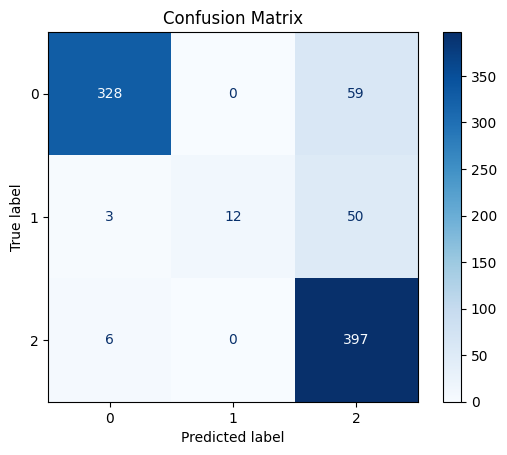

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# --- UPDATED EVALUATION FUNCTION ---
def evaluate_model():
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)

            # Store true and predicted labels
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    # Accuracy Calculation
    accuracy = np.sum(np.array(true_labels) == np.array(pred_labels)) / len(true_labels)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
print("Evaluating Model...")
evaluate_model()